In [115]:
import numpy as np
import random
import os
import cv2
from utils import *
import matplotlib.pyplot as plt
import pprint
import json
import torch
from detection import transforms as T

In [116]:
import os
import time
import datetime

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection as M
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

from detection import coco_utils, presets, utils, transforms
from detection.engine import train_one_epoch, evaluate

In [117]:
train_path = 'chess/train'

In [118]:
# 5 random photos
photos_names = list(np.random.choice(os.listdir(train_path), 1))
photos = [os.path.join(train_path, photo) for photo in photos_names]
photos = [cv2.imread(photo) for photo in photos]

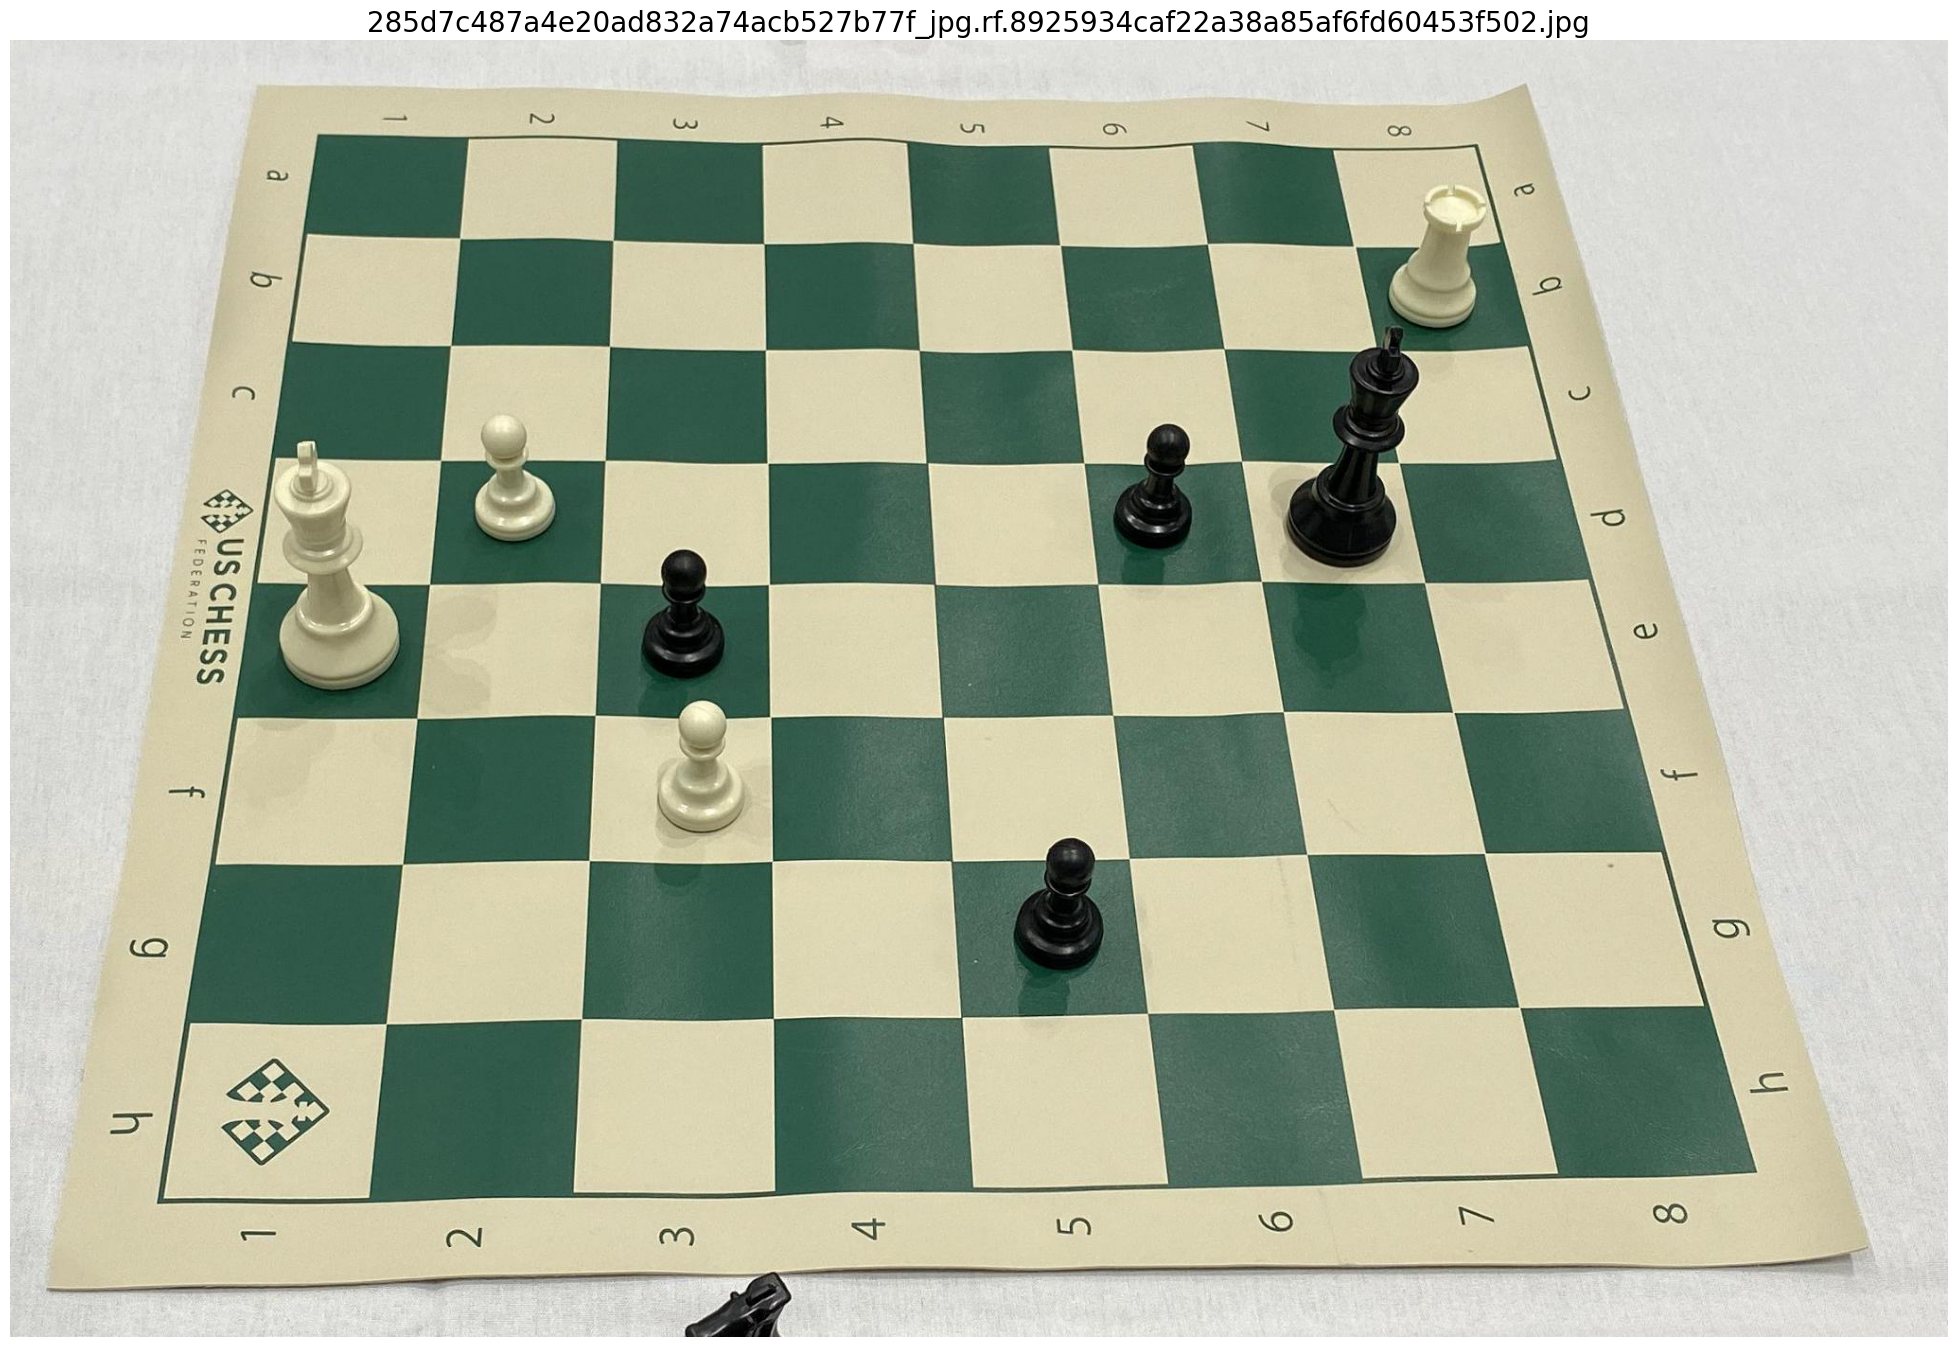

In [119]:
display_images(photos, photos_names)

In [120]:
annotation = 'chess/train/_annotations.coco.json'
annotation = json.load(open(annotation))

In [121]:
annotation.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [122]:
annotation['annotations'][0]

{'id': 0,
 'image_id': 0,
 'category_id': 13,
 'bbox': [839, 260, 119, 175],
 'area': 20825,
 'segmentation': [],
 'iscrowd': 0}

In [123]:
id = 383

In [124]:
bbox = annotation['annotations'][id]['bbox']
image_id = annotation['annotations'][id]['image_id']
name = [image['file_name'] for image in annotation['images'] if image['id'] == image_id][0]

In [125]:
image = cv2.imread(os.path.join(train_path, name))
x, y, w, h = bbox

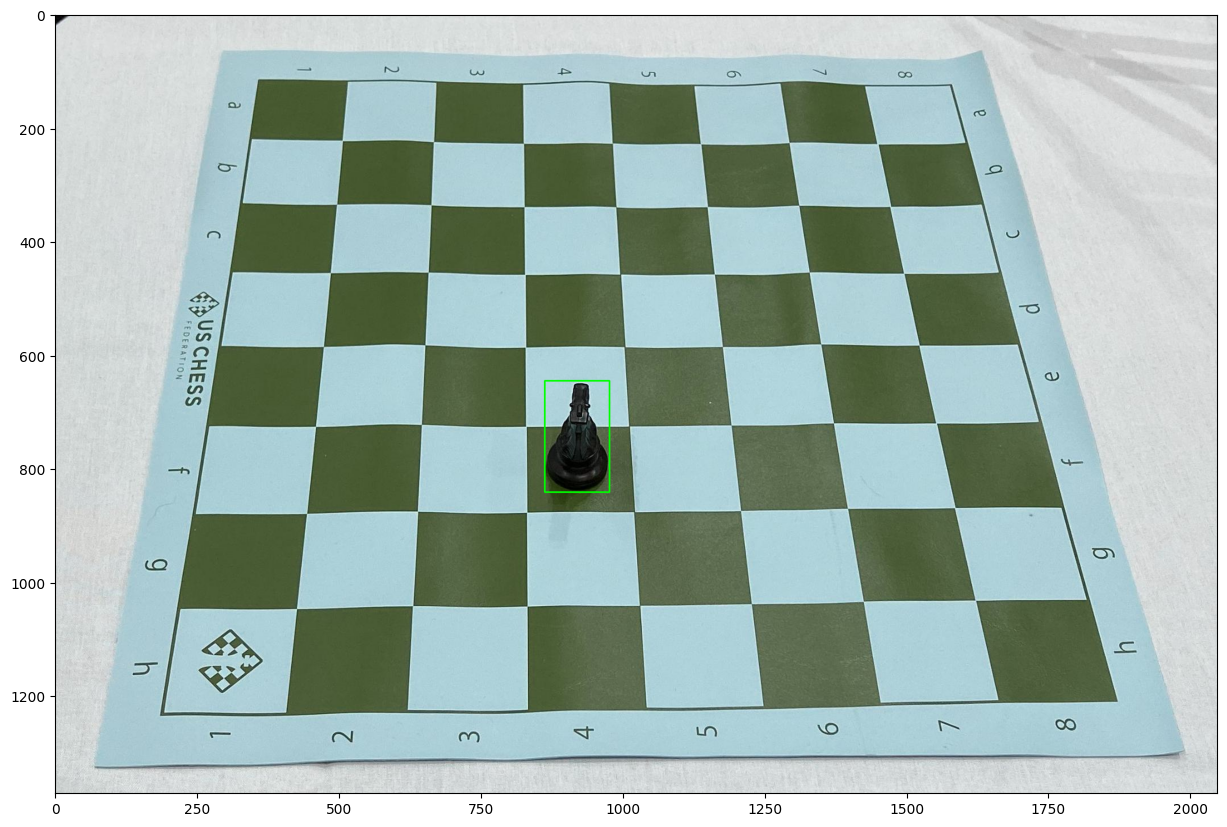

In [126]:
cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), (0, 255, 0), 2)
plt.figure(figsize=(15, 15))
plt.imshow(image)

# Scripts

In [127]:
def get_dataset(img_root:str, file_name:str, train:bool=True):
    """Reimplementacja analogicznej funkcji z pakietu references, rozwiązująca drobną niekompatybilność w zbiorze CPD"""
    def fake_segmentation(image, target):
        for obj in target['annotations']:
            x, y, w, h = obj['bbox']
            segm = [x, y, x+w, y, x+w, y+h, x, y+h]
            obj['segmentation'] = [segm]
        return image, target

    tfs = transforms.Compose([
        fake_segmentation,
        coco_utils.ConvertCocoPolysToMask(),
        presets.DetectionPresetTrain(data_augmentation='hflip') if train else presets.DetectionPresetEval(),
        # jeśli chcesz dodać swoje własne augmentacje, możesz zrobić to tutaj
    ])
    ds = coco_utils.CocoDetection(img_root, file_name, transforms=tfs)
    return ds

In [128]:
# Konfiguracja hiperparametrów
LR = 0.001 # powinno być dobrze dla 1 GPU
WDECAY = 0.0001
EPOCHS = 25
VAL_FREQ = 5 # walidacja i checkpointowanie co N epok
BATCH_SIZE = 8 # dobierz pod możliwości sprzętowe
NUM_WORKERS = 0 # j/w
NUM_CLASSES = 14
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DATASET_ROOT = 'chess/'
OUTPUT_DIR = 'out2/'

In [129]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [130]:
# Zaczytanie datasetów
chess_train = get_dataset(os.path.join(DATASET_ROOT, 'train'), os.path.join(DATASET_ROOT, 'train/_annotations.coco.json'))
chess_val = get_dataset(os.path.join(DATASET_ROOT, 'valid'), os.path.join(DATASET_ROOT, 'valid/_annotations.coco.json'))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [131]:
chess_train[0]

(tensor([[[0.8902, 0.8863, 0.8784,  ..., 0.8157, 0.8196, 0.8235],
          [0.8902, 0.8863, 0.8784,  ..., 0.8275, 0.8275, 0.8275],
          [0.8863, 0.8824, 0.8784,  ..., 0.8353, 0.8353, 0.8353],
          ...,
          [0.8157, 0.8275, 0.8196,  ..., 0.8667, 0.9059, 0.9020],
          [0.8118, 0.8235, 0.8157,  ..., 0.8314, 0.8627, 0.8549],
          [0.8078, 0.8196, 0.8078,  ..., 0.8157, 0.8392, 0.8314]],
 
         [[0.8902, 0.8863, 0.8784,  ..., 0.8157, 0.8196, 0.8235],
          [0.8902, 0.8863, 0.8784,  ..., 0.8275, 0.8275, 0.8275],
          [0.8863, 0.8824, 0.8784,  ..., 0.8353, 0.8353, 0.8353],
          ...,
          [0.8157, 0.8275, 0.8196,  ..., 0.8667, 0.9059, 0.9020],
          [0.8118, 0.8235, 0.8157,  ..., 0.8314, 0.8627, 0.8549],
          [0.8078, 0.8196, 0.8078,  ..., 0.8157, 0.8392, 0.8314]],
 
         [[0.8824, 0.8784, 0.8706,  ..., 0.8157, 0.8196, 0.8235],
          [0.8824, 0.8784, 0.8706,  ..., 0.8275, 0.8275, 0.8275],
          [0.8784, 0.8745, 0.8706,  ...,

In [132]:
img, masks = chess_train[0][0], chess_train[0][1]['masks']

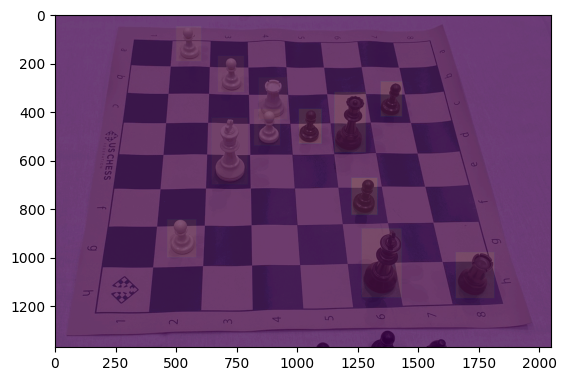

In [133]:
plt.imshow(img.permute(1, 2, 0))
for mask in masks:
    plt.imshow(mask, alpha=0.1)

random flip nie zaburza maski?

In [134]:
# samplery i loadery
train_sampler = torch.utils.data.RandomSampler(chess_train)
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, BATCH_SIZE, drop_last=True)
train_loader = torch.utils.data.DataLoader(
    chess_train, batch_sampler=train_batch_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

val_sampler = torch.utils.data.SequentialSampler(chess_val)
val_loader = torch.utils.data.DataLoader(
    chess_val, batch_size=1, sampler=val_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

In [135]:
for i in train_sampler:
    print(i)
    break

181


In [136]:
for i in train_batch_sampler:
    print(i)
    break

[123, 94, 2, 145, 38, 53, 103, 84]


In [137]:
train_loader.dataset[0]

(tensor([[[0.8902, 0.8863, 0.8784,  ..., 0.8157, 0.8196, 0.8235],
          [0.8902, 0.8863, 0.8784,  ..., 0.8275, 0.8275, 0.8275],
          [0.8863, 0.8824, 0.8784,  ..., 0.8353, 0.8353, 0.8353],
          ...,
          [0.8157, 0.8275, 0.8196,  ..., 0.8667, 0.9059, 0.9020],
          [0.8118, 0.8235, 0.8157,  ..., 0.8314, 0.8627, 0.8549],
          [0.8078, 0.8196, 0.8078,  ..., 0.8157, 0.8392, 0.8314]],
 
         [[0.8902, 0.8863, 0.8784,  ..., 0.8157, 0.8196, 0.8235],
          [0.8902, 0.8863, 0.8784,  ..., 0.8275, 0.8275, 0.8275],
          [0.8863, 0.8824, 0.8784,  ..., 0.8353, 0.8353, 0.8353],
          ...,
          [0.8157, 0.8275, 0.8196,  ..., 0.8667, 0.9059, 0.9020],
          [0.8118, 0.8235, 0.8157,  ..., 0.8314, 0.8627, 0.8549],
          [0.8078, 0.8196, 0.8078,  ..., 0.8157, 0.8392, 0.8314]],
 
         [[0.8824, 0.8784, 0.8706,  ..., 0.8157, 0.8196, 0.8235],
          [0.8824, 0.8784, 0.8706,  ..., 0.8275, 0.8275, 0.8275],
          [0.8784, 0.8745, 0.8706,  ...,

In [138]:
img, masks = train_loader.dataset[0][0], train_loader.dataset[0][1]['masks']
masks

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

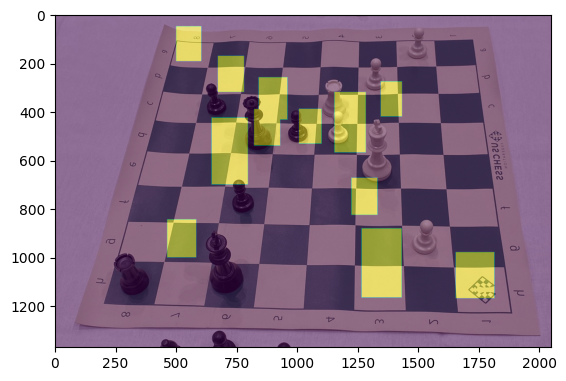

In [139]:
plt.imshow(img.permute(1, 2, 0))
join_mask = torch.zeros_like(masks[0])
for mask in masks:
    join_mask += mask
join_mask = torch.clip(join_mask, 0, 1)
plt.imshow(join_mask, alpha=0.5)
plt.show()

# MODEL

In [140]:
# Skonstruowanie modelu; tworzymy w wersji dla 91 klas aby zainicjować wagi wstępnie nauczone na COCO...
model = M.fasterrcnn_resnet50_fpn(weights=M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, num_classes=91).to(DEVICE)
# ...po czym zastępujemy predyktor mniejszym, dostosowanym do naszego zbioru:
model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_channels=1024, num_classes=NUM_CLASSES).to(DEVICE)

In [141]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

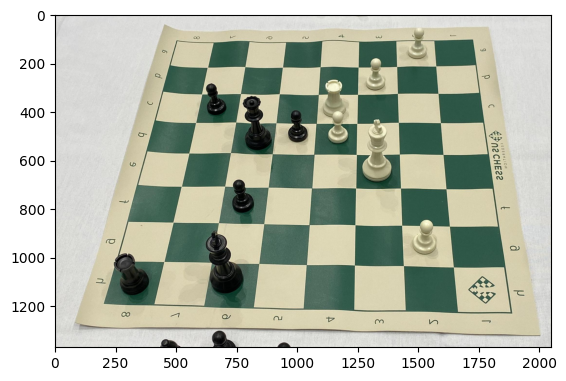

In [183]:
# get random image 
img, _ = chess_train[0]
plt.imshow(img.permute(1, 2, 0))

In [184]:
img.shape

torch.Size([3, 1371, 2048])

In [185]:
height, width = img.shape[1:]
height, width

(1371, 2048)

In [203]:
with torch.no_grad():
    model.eval()
    out = model.backbone(img.unsqueeze(0).to(DEVICE))

In [204]:
out.keys()

odict_keys(['0', '1', '2', '3', 'pool'])

In [205]:
out['0'].shape, out['1'].shape, out['2'].shape, out['3'].shape, out['pool'].shape

(torch.Size([1, 256, 343, 512]),
 torch.Size([1, 256, 172, 256]),
 torch.Size([1, 256, 86, 128]),
 torch.Size([1, 256, 43, 64]),
 torch.Size([1, 256, 22, 32]))

In [206]:
out = out['pool']

In [208]:
out.shape

torch.Size([1, 256, 22, 32])

In [209]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(image):
    dpi = plt.rcParams["figure.dpi"]
    height, width = image.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


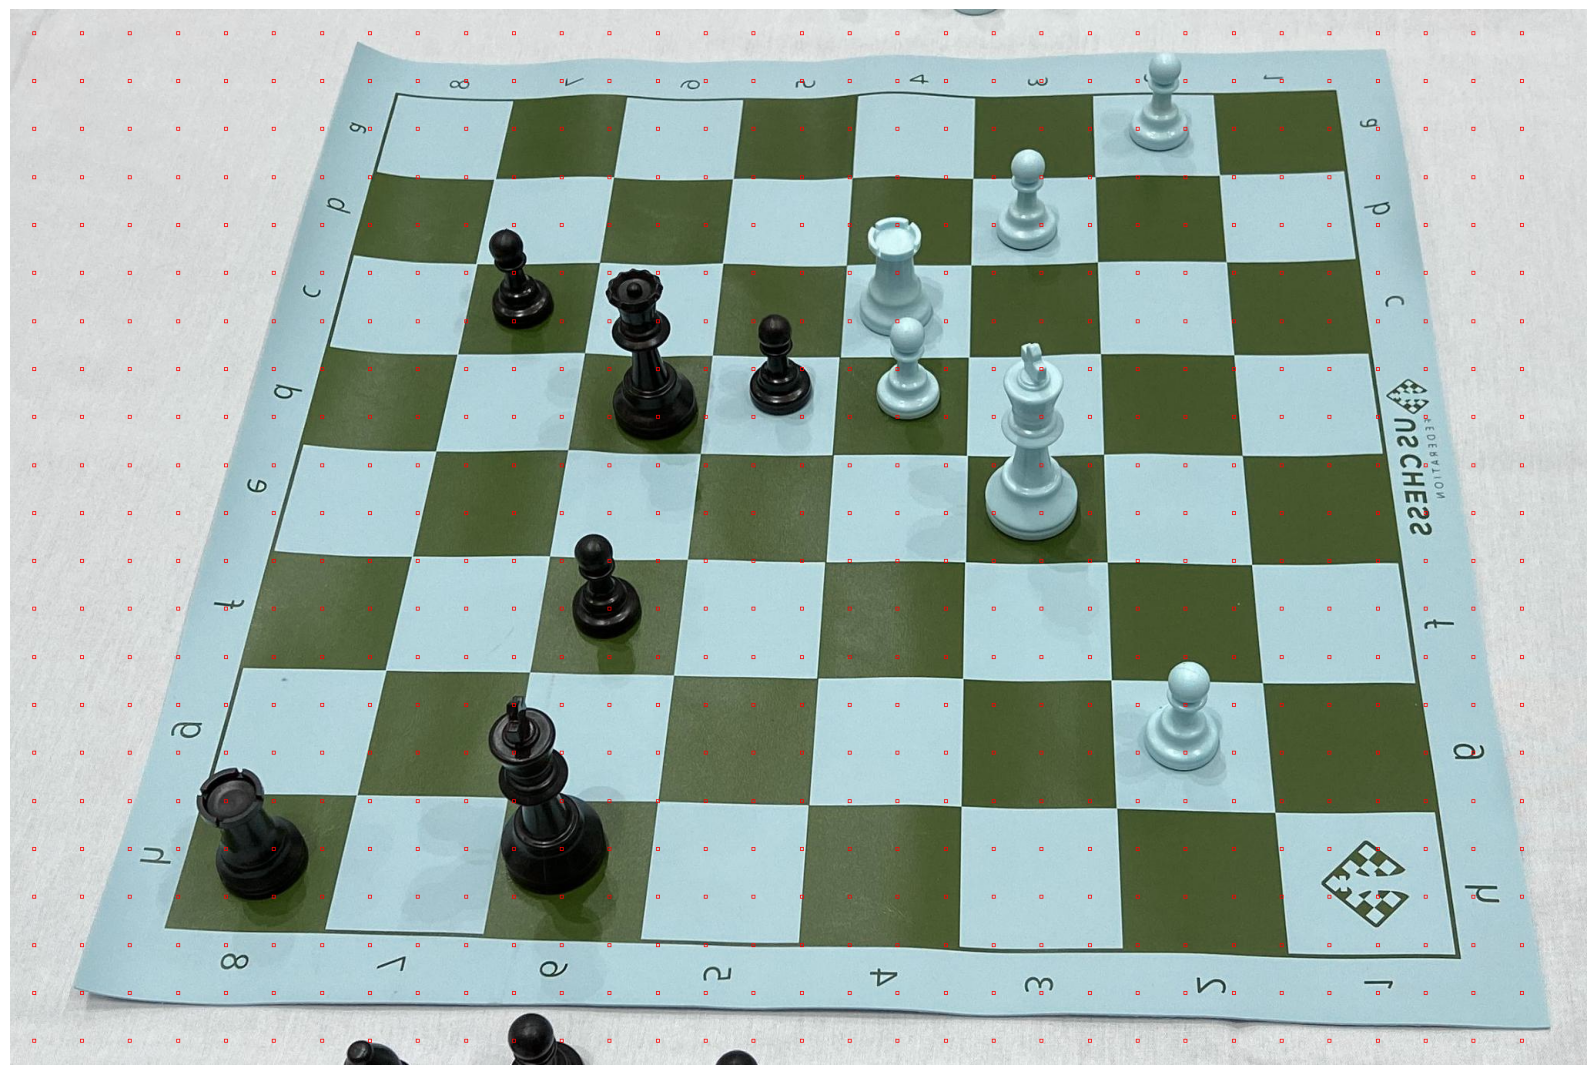

In [212]:
feature_h, feature_w = out.shape[2:]
sub_sample = height/feature_h
new_img = img.permute(1, 2, 0).numpy().copy()
rect_w = 4
rect_h = 4
for i in range(feature_h):
    for j in range(feature_w):
        center_x = sub_sample * j + sub_sample/2
        center_y = sub_sample * i + sub_sample/2
        start_x = int(center_x - rect_w/2)
        start_y = int(center_y - rect_h/2)
        end_x = int(center_x + rect_w/2)
        end_y = int(center_y + rect_h/2)
        cv2.rectangle(new_img, (start_x, start_y), (end_x, end_y), (0, 0, 255))
imshow(new_img[:,:,::-1])

In [224]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [226]:
# print iou thresholds
model.rpn.box_coder

In [225]:
# model.rpn.anchor_generator([out])

AttributeError: 'RegionProposalNetwork' object has no attribute 'iou_types'

In [228]:
# model.roi_heads
# print thresholds
model.roi_heads.box_coder

In [232]:
# Dostosowanie progów
model.roi_heads.score_thresh, model.roi_heads.nms_thresh

(0.05, 0.5)